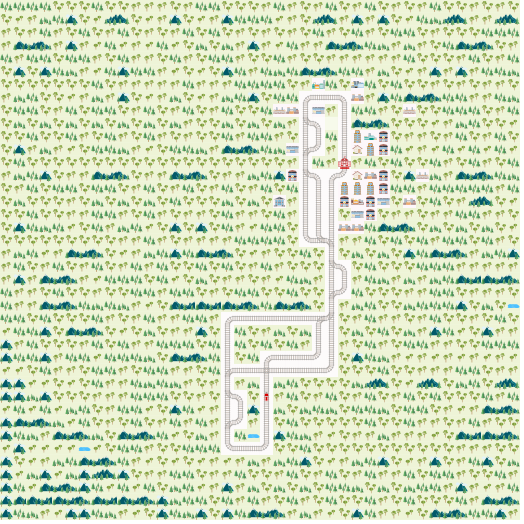

In [ ]:
import numpy as np

from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.utils.rendertools import RenderTool, AgentRenderVariant
from tensorflow.python.keras.optimizer_v2.adam import Adam

from project.dqn.agent import SingleDQNAgent
from project.dqn.environment import SingleAgentEnvironment
from project.obs.single import SingleDQNAgentObs

from IPython.display import clear_output


%matplotlib inline

random_seed = 42
np.random.seed(random_seed)

action_to_direction = {0: 'no-op', 1: 'left', 2: 'forward', 3: 'right', 4: 'halt'}

EPISODES = 100
TIMESTEPS = 2000

WIDTH = 40
HEIGHT = 40

BATCH_SIZE = 32

env = RailEnv(
    width=WIDTH,
    height=HEIGHT,
    rail_generator=sparse_rail_generator(
        # Number of cities (= train stations)
        max_num_cities=3,
        # Distribute the cities evenly in a grid
        grid_mode=False,
        # Max number of rails connecting to a city
        max_rails_between_cities=1,
        # Number of parallel tracks in cities
        max_rails_in_city=1,
        seed=random_seed),
    obs_builder_object=SingleDQNAgentObs(),
    number_of_agents=1,
    random_seed=random_seed)

environment = SingleAgentEnvironment(env)
agent = SingleDQNAgent(environment, Adam(lr=0.01))

agent.q_network.summary()

"""
Transform observation dictionary to neural network input (numpy column)
Args:
    observation: the observation to change
"""


def reshape_observation(observation):
    pos = [observation[0]["state"][0], observation[0]["state"][1]]
    observation = [i for row in observation[0]["observations"] for i in row]
    observation.extend(pos)

    return np.array(observation).reshape((-1, 11))


for e in range(0, EPISODES):
    # Reset the environment
    #environment.reset_renderer()
    old_observation = environment.reset()

    old_observation = reshape_observation(old_observation)

    # Initialize variables
    reward = 0
    terminated = False

    for time_step in range(TIMESTEPS):
        # Get an action exploiting the knowledge (neural network) or exploring
        action = agent.act(old_observation)

        # Apply the chosen action
        new_observation, reward, terminated, info = environment.step(action)
        
        print(new_observation)
        print(reward)
        print(terminated)
        print(info)
        print("_______________________________")

        reward = reward[0]
        terminated = terminated[0]

        # Reshape the observation to feed the network
        new_observation = reshape_observation(new_observation)

        # Store S A R S'
        agent.store(old_observation, action, reward, new_observation, terminated)

        old_observation = new_observation

        clear_output(wait=True)
        environment.render()

        # Termination causes the end of the episode
        if terminated:
            agent.update_target_model()
            #environment.close_window()
            break

        # Retrain when the batch is ready
        if len(agent.replay_buffer) > BATCH_SIZE:
            agent.retrain(BATCH_SIZE)

    if (e + 1) % 10 == 0:
        print("**********************************")
        print("Episode: {}".format(e + 1))
        # environment.render()
        print("**********************************")
